In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('/content/GOOG.csv')

# Display the first few rows of the dataset
df.head()



,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-06-14 00:00:00+00:00,718.27,722.47,713.1200,716.48,1306065,718.27,722.47,713.1200,716.48,1306065,0.0,1.0
1,GOOG,2016-06-15 00:00:00+00:00,718.92,722.98,717.3100,719.00,1214517,718.92,722.98,717.3100,719.00,1214517,0.0,1.0
2,GOOG,2016-06-16 00:00:00+00:00,710.36,716.65,703.2600,714.91,1982471,710.36,716.65,703.2600,714.91,1982471,0.0,1.0
3,GOOG,2016-06-17 00:00:00+00:00,691.72,708.82,688.4515,708.65,3402357,691.72,708.82,688.4515,708.65,3402357,0.0,1.0
4,GOOG,2016-06-20 00:00:00+00:00,693.71,702.48,693.4100,698.77,2082538,693.71,702.48,693.4100,698.77,2082538,0.0,1.0


In [6]:
data = df['close'].values
data = data.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()


In [7]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).requires_grad_()
        c_0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).requires_grad_()

        lstm_out, _ = self.lstm(input_seq, (h_0.detach(), c_0.detach()))
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

model = LSTMModel()


In [11]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

for epoch in range(epochs):
    model.train()

    optimizer.zero_grad()

    y_pred = model(X_train)

    loss = loss_function(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch} Loss: {loss.item()}')


Epoch 0 Loss: 0.009173731319606304
Epoch 10 Loss: 0.007666513789445162
Epoch 20 Loss: 0.005684216506779194
Epoch 30 Loss: 0.0013355094706639647
Epoch 40 Loss: 0.0010529950959607959
Epoch 50 Loss: 0.0008720458718016744
Epoch 60 Loss: 0.000654356786981225
Epoch 70 Loss: 0.0005471071344800293
Epoch 80 Loss: 0.0004887499962933362
Epoch 90 Loss: 0.0004379709134809673


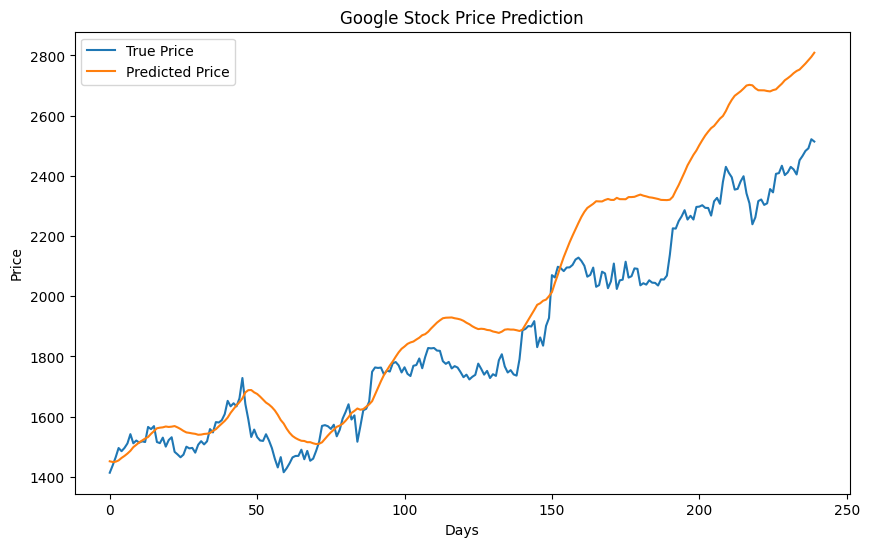

In [12]:
model.eval()
with torch.no_grad():
    train_predict = model(X_test)

# Inverse transform the predictions
train_predict = scaler.inverse_transform(train_predict.numpy())
y_test = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Price')
plt.plot(train_predict, label='Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()
